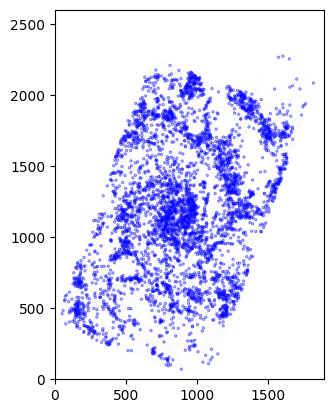

In [1]:
import numpy as np
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture



tf = 5.0

original_image_path = r"/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/ngc0628_F770W/CDD/ngc0628_F770W_JWST_Emission_starsub_CDDss0016pc.fits"
with fits.open(original_image_path) as hdul:
    data = hdul[0].data
    header = hdul[0].header

data = np.nan_to_num(data, nan=0.0)  # Replace NaNs with 0
mean, median, std = sigma_clipped_stats(data, sigma=3.0)
daofind = DAOStarFinder(fwhm=3.0, threshold=tf*std)
sources = daofind(data - median)

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.0)
norm = ImageNormalize(stretch=SqrtStretch())

# Plot the data with apertures
plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)
plt.show()

# Save the figure as a FITS file
save_path = r"/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/ngc0628_F770W_JWST_Emission_starsub_CDDss0016pc_CDD_Sources.fits"

# Create a blank mask (same shape as the image data)
mask = np.zeros_like(data, dtype=int)

# Generate the mask for each aperture and place it at the corresponding position in the full image
for pos in positions:
    aperture = CircularAperture(pos, r=7.0)  # Create aperture for each position
    aperture_mask = aperture.to_mask(method='center')  # Create a mask for each aperture
    
    # Get the shape of the aperture mask
    aperture_shape = aperture_mask.data.shape
    
    # The aperture is centered on the position of the source
    y_center, x_center = int(pos[1]), int(pos[0])  # Get position of centroid
    
    # Ensure that the indices are within the bounds of the image
    y_min = max(0, y_center - aperture_shape[0] // 2)
    y_max = min(mask.shape[0], y_center + aperture_shape[0] // 2)
    x_min = max(0, x_center - aperture_shape[1] // 2)
    x_max = min(mask.shape[1], x_center + aperture_shape[1] // 2)

    # Place the aperture mask on the correct part of the full mask
    mask[y_min:y_max, x_min:x_max] = np.maximum(
        mask[y_min:y_max, x_min:x_max],
        aperture_mask.data[
            aperture_shape[0] // 2 - (y_center - y_min):aperture_shape[0] // 2 + (y_max - y_center),
            aperture_shape[1] // 2 - (x_center - x_min):aperture_shape[1] // 2 + (x_max - x_center)
        ].astype(int)
    )   

# Check the mask output
# Save the mask as a FITS file
hdu = fits.PrimaryHDU(mask, header=header)
hdu.writeto(save_path, overwrite=True)



In [ ]:
from julia.api import Julia
julia = Julia(compiled_modules=False)

# Import the necessary Julia modules using an alias if necessary to avoid conflicts
from julia import Main

# Set paths for the image and mask
image_path = "/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/ngc0628_F770W/CDD/ngc0628_F770W_JWST_Emission_starsub_CDDss0016pc.fits"
mask_path = "/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/ngc0628_F770W_JWST_Emission_starsub_CDDss0016pc_CDD_Sources.fits"

# Run the Julia code within the Main namespace to avoid conflicts
Main.eval(f"""
using FITSIO
using StatsBase
using CloudClean
                  
# Load the raw image
f = FITSIO.FITS("{image_path}")
raw_image = read(f[1])
header = read_header(f[1])
close(f)
println("Shape of raw_image: ", size(raw_image))

# Create a copy for the out_image
out_image = copy(raw_image)
println("Shape of out_image: ", size(out_image))

# Load the mask
f = FITSIO.FITS("{mask_path}")
raw_mask = read(f[1])
close(f)
println("Shape of raw_mask: ", size(raw_mask))

# Convert the raw mask data into a boolean mask
bimage = raw_mask .!= 0

# Set parameters
Np = 33
out_image[bimage] .= 0

# Count the masked pixels
println("Number of masked pixels: ", count(bimage))

# Display the region around (cenx, ceny)
cenx = 579
ceny = 579
dv = 250
println("Indexing range for x: ", (cenx-dv), ":", (cenx+dv))
println("Indexing range for y: ", (ceny-dv), ":", (ceny+dv))
vmin, vmax = quantile(out_image[(cenx-dv):(cenx+dv), (ceny-dv):(ceny+dv)], [0.02, 0.99])

# Assuming proc_continuous is defined elsewhere:
star_stats = proc_continuous(out_image, bimage, Np=Np, tilex=4, ftype=64, widx=129, seed=2022, ndraw=0)
println("Shape of star_stats: ", size(star_stats))

# Save the outputs to files instead of displaying
using FITSIO


# Save the mean infill result
f = FITSIO.FITS("mean_infill.fits", "w");
FITSIO.write(f, star_stats[1]; header=header)
close(f)

# Save the draw infill result
f = FITSIO.FITS("draw_infill.fits", "w");
FITSIO.write(f, star_stats[2]; header=header)
close(f)

println("Outputs saved to files: masked_original.fits, mean_infill.fits, draw_infill.fits, original_image.fits")
""")

Shape of raw_image: (1891, 2600)
Shape of out_image: (1891, 2600)
Shape of raw_mask: (1891, 2600)
Number of masked pixels: 543942
Indexing range for x: 329:829
Indexing range for y: 329:829
Infilling completed after 3 rounds with final width (widx,widy) = (51,51)
Finished 188 of 30704 locations in tile (1, 1)
Finished 166 of 28813 locations in tile (1, 2)
Finished 39 of 6430 locations in tile (1, 3)
Finished 0 of 0 locations in tile (1, 4)
Finished 179 of 29012 locations in tile (2, 1)
Finished 571 of 111809 locations in tile (2, 2)
Finished 447 of 80086 locations in tile (2, 3)
Finished 92 of 15389 locations in tile (2, 4)
Finished 162 of 30237 locations in tile (3, 1)
Finished 424 of 80790 locations in tile (3, 2)
Finished 370 of 70720 locations in tile (3, 3)
Finished 83 of 18819 locations in tile (3, 4)
Finished 0 of 0 locations in tile (4, 1)
Finished 34 of 5864 locations in tile (4, 2)
Had to use SVD for sqrt_cov at (x,y) = (1553,1899)
Finished 182 of 33741 locations in tile (4, 

JuliaError: Exception 'MethodError: no method matching write(::FITS, ::Float64; header::FITSHeader)
The function `write` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  write(::FITS, !Matched::AbstractDict{<:AbstractString}; units, header, hdutype, name, ver, varcols)
   @ FITSIO ~/.julia/packages/FITSIO/VqV3x/src/table.jl:418
  write(::FITS, !Matched::Vector{String}, !Matched::Vector; units, header, hdutype, name, ver, varcols)
   @ FITSIO ~/.julia/packages/FITSIO/VqV3x/src/table.jl:368
  write(::FITS, !Matched::StridedArray{<:Real}; header, name, ver)
   @ FITSIO ~/.julia/packages/FITSIO/VqV3x/src/image.jl:350
  ...
' occurred while calling julia code:

using FITSIO
using StatsBase
using CloudClean

# Load the raw image
f = FITSIO.FITS("/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/ngc0628_F770W/CDD/ngc0628_F770W_JWST_Emission_starsub_CDDss0016pc.fits")
raw_image = read(f[1])
header = read_header(f[1])
close(f)
println("Shape of raw_image: ", size(raw_image))

# Create a copy for the out_image
out_image = copy(raw_image)
println("Shape of out_image: ", size(out_image))

# Load the mask
f = FITSIO.FITS("/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/ngc0628_F770W_JWST_Emission_starsub_CDDss0016pc_CDD_Sources.fits")
raw_mask = read(f[1])
close(f)
println("Shape of raw_mask: ", size(raw_mask))

# Convert the raw mask data into a boolean mask
bimage = raw_mask .!= 0

# Set parameters
Np = 33
out_image[bimage] .= 0

# Count the masked pixels
println("Number of masked pixels: ", count(bimage))

# Display the region around (cenx, ceny)
cenx = 579
ceny = 579
dv = 250
println("Indexing range for x: ", (cenx-dv), ":", (cenx+dv))
println("Indexing range for y: ", (ceny-dv), ":", (ceny+dv))
vmin, vmax = quantile(out_image[(cenx-dv):(cenx+dv), (ceny-dv):(ceny+dv)], [0.02, 0.99])

# Assuming proc_continuous is defined elsewhere:
star_stats = proc_continuous(out_image, bimage, Np=Np, tilex=4, ftype=64, widx=129, seed=2022, ndraw=0)
println("Shape of star_stats: ", size(star_stats))

# Save the outputs to files instead of displaying
using FITSIO


# Save the mean infill result
f = FITS("mean_infill.fits", "w");
write(f, star_stats[1]; header=header)
close(f)

# Save the draw infill result
f = FITS("draw_infill.fits", "w");
write(f, star_stats[2]; header=header)
close(f)

println("Outputs saved to files: masked_original.fits, mean_infill.fits, draw_infill.fits, original_image.fits")
